In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import tensorflow as tf
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import platform
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import sklearn.metrics as metrics
from keras.optimizers import RMSprop
from keras.utils.np_utils import to_categorical
from imblearn.under_sampling import TomekLinks
import cv2 
from glob import glob
from random import shuffle
from tensorflow.data import Dataset, Iterator
from tqdm import tqdm  
import scipy
import skimage
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score 
import itertools
from skimage.transform import resize
import pathlib
pathlib.Path.cwd()
from sklearn.preprocessing import LabelBinarizer
import scikitplot as skplt



WindowsPath('C:/Users/jrizz_000/hacks/Mod 4')

In [436]:
train_dir = 'chest_xray/chest_xray/train'
test_dir = 'chest_xray/chest_xray/test'

def show_img(train_dir, train_gen):
    
    image_path = train_dir + "/" + train_gen.filenames[index]
    image = mpimg.imread(image_path)
    #BGR TO RGB conversion using CV2
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    fig=plt.figure(figsize=(8, 8))

    columns = 4
    rows = 5

    for i in range(1, columns*rows +1):
        
        

        fig.add_subplot(rows, columns, i)
        pixels = np.array(image)
        plt.imshow(pixels)


        if probability > 0.5:
            plt.title("%.1f" % (probability[0]*100) + "% Normal ")
        else:
            plt.title("%.1f" % ((1-probability[0])*100) + "% Pneumonia ")
    plt.tight_layout(True)
    plt.show()

# Data Augmentation

In [44]:
# Data Augmentation

def process_data(train, test, ig_size, batch_size):
    #to prevent overfitting
    train_datagen = ImageDataGenerator(rotation_range=90,
                                    width_shift_range=100,
                                    height_shift_range=100,
                                    rescale=1./255, zoom_range=0.3,
                                    horizontal_flip=True, vertical_flip=True)
    

    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    #feeding the network to the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=train, 
    target_size=(ig_size, ig_size), 
    batch_size=batch_size, 
    class_mode='categorical', 
    shuffle=True,color_mode='rgb')
    

    test_gen = test_val_datagen.flow_from_directory(
    directory=test, 
    target_size=(ig_size, ig_size), 
    batch_size= batch_size, 
    class_mode='categorical', 
    shuffle=False,color_mode='rgb')
    

    
    return train_gen, test_gen 

# Modelling

In [114]:
def get_model(transferleaner, train_gen, test_gen, epoch):
    m = transferleaner
    model = Model(inputs = m.input, outputs = pred)

    model.summary()

    model.compile(loss='categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy'])
    
    model.fit(train_gen,  validation_data = test_gen,
                       epochs = epoch, steps_per_epoch = len(train_gen),
                       validation_steps = len(test_gen))
    
    h = model.fit(train_gen,  validation_data = test_gen,
                       epochs = epoch, steps_per_epoch = len(train_gen),
                       validation_steps = len(test_gen))
    
    return model, h

## Confusion Matrix

In [174]:
def plot_confusion_matrix(model, test_gen, batch_size):
    
    classes = ['NORMAL','PNEUMONIA']
    tick_marks = [0.5,1.5]
      
    
    test_gen.reset()
    
    Y_pred = model.predict(test_gen, test_gen.samples // test_gen.batch_size+1)
    y_pred = np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    cm = confusion_matrix(test_gen.classes, y_pred)

    target_names = ['NORMAL', 'PNEUMONIA']
    
    sns.heatmap(cm,cmap='Purples',annot=True)
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    
    print("Precision Score: {}".format(precision_score(test_gen.classes, y_pred)))
    print("Recall Score: {}".format(recall_score(test_gen.classes, y_pred)))
    print("Accuracy Score: {}".format(accuracy_score(test_gen.classes, y_pred)))
    print("F1 Score: {}".format(f1_score(test_gen.classes, y_pred)))
    
    return plt.show()
    
        
   


## Model Loss

In [152]:
def plot_learning_curves(r):
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    plt.plot(r.history['loss'])
    plt.plot(r.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.grid(True)
    
    plt.subplot(1,2,2)
    plt.plot(r.history['accuracy'])
    plt.plot(r.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    
    return plt.show()

# ROC & AUC

In [171]:
def multiclass_roc_auc_score(test_gen, model, average="micro"):
    from sklearn import preprocessing
    
    lb = preprocessing.LabelBinarizer()
    fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
    
    test_gen.reset()
    
    Y_pred = model.predict(test_gen, test_gen.samples // test_gen.batch_size+1) 
    y_pred = np.argmax(Y_pred, axis=1)
    
    y_test = test_gen.classes
    
    
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    
    lb = preprocessing.LabelBinarizer()   
    lb.fit(y_pred)
    y_pred = lb.transform(y_pred)
 
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
    auc_keras = auc(fpr_keras, tpr_keras)


    plt.figure(1)
    plt.plot(fpr_keras, tpr_keras, color='darkorange', label='ROC curve (area = %0.2f)' % auc_keras)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.grid(True)
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

    return plt.show()



## ResNet50

In [ ]:
## ResNet50

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input


# calling ResNet50 and removing the last layer since I dont need it
res = ResNet50(input_shape = ig_size + [3], weights = 'imagenet', include_top = False)



# I dont have to train the layers since ResNet is already trained
for layer in res.layers:
    layer.trainable = False

# flatting the last layer
x = Flatten()(res.output)

x =  Dense(1024, activation='relu')(x)
x =  Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)


pred = Dense(len(root), activation = 'softmax' )(x)


model = Model(inputs = res.input, outputs = pred)



model.summary()


model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

genfor_train = ImageDataGenerator(rescale = 1./255, shear_range = 0.2,
                                   zoom_range = 0.2,horizontal_flip = True)

genfor_test = ImageDataGenerator(rescale = 1./255)

training_set = genfor_train.flow_from_directory(train,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

testing_set = genfor_train.flow_from_directory(test,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

res = model.fit_generator(training_set, validation_data = testing_set,
                       epochs = 20, steps_per_epoch = len(training_set),
                       validation_steps = len(testing_set))

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
163/163 [==============================] - 1468s 9s/step - loss: 1.4003 - accuracy: 0.7510 - val_loss: 0.6705 - val_accuracy: 0.6779
Epoch 2/20
163/163 [==============================] - 957s 6s/step - loss: 0.3381 - accuracy: 0.8493 - val_loss: 0.4249 - val_accuracy: 0.8141
Epoch 3/20
163/163 [==============================] - 946s 6s/step - loss: 0.2880 - accuracy: 0.8771 - val_loss: 0.4652 - val_accuracy: 0.7981
Epoch 4/20
163/163 [==============================] - 1068s 7s/step - loss: 0.3231 - accuracy: 0.8692 - val_loss: 0.3843 - val_accuracy: 0.8301
Epoch 5/20
163/163 [==============================] - 901s 6s/step - loss: 0.2908 - accuracy: 0.8719 - val_loss: 1.2144 - val_accuracy: 0.6346
Epoch 6/20
163/163 [==============================] - 898s 6s/step - loss: 0.2802 - accuracy: 0.8836 - val_loss: 0.3874 - va

## ResNet50 Testing

In [ ]:
## Confusion matrix
plot_confusion_matrix(h1, test_gen, batch_size)
## Learning curve
plot_learning_curves(h2)
## ROC AUC
multiclass_roc_auc_score(test_gen, h1)

## VGG16

In [112]:
# VGG16


train = "chest_xray/chest_xray/train/"
test =  "chest_xray/chest_xray/test/"

ig_size=224
root = glob('chest_xray/chest_xray/train/*')
epoch = 5
batch_size = 32

vgg = VGG16(input_shape = [ig_size,ig_size] + [3], weights = 'imagenet', include_top = False)

for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)


x = Dense(480, activation='relu')(x)

pred = Dense(len(root), activation = 'softmax' )(x)

train_gen, test_gen  = process_data(train, test, ig_size, batch_size)



Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [115]:
h1, h2  = get_model(vgg, train_gen, test_gen, epoch)

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

163/163 [==============================] - ETA: 0s - loss: 0.5495 - accuracy: 0.84 - ETA: 13:05 - loss: 6.3418 - accuracy: 0.781 - ETA: 17:19 - loss: 5.0784 - accuracy: 0.822 - ETA: 19:20 - loss: 4.3601 - accuracy: 0.820 - ETA: 20:41 - loss: 3.7298 - accuracy: 0.737 - ETA: 21:36 - loss: 3.1779 - accuracy: 0.744 - ETA: 22:01 - loss: 2.8040 - accuracy: 0.754 - ETA: 22:19 - loss: 2.5105 - accuracy: 0.757 - ETA: 22:32 - loss: 2.2916 - accuracy: 0.756 - ETA: 22:39 - loss: 2.1302 - accuracy: 0.753 - ETA: 22:44 - loss: 1.9531 - accuracy: 0.769 - ETA: 22:47 - loss: 1.8354 - accuracy: 0.765 - ETA: 22:53 - loss: 1.7291 - accuracy: 0.766 - ETA: 22:51 - loss: 1.6453 - accuracy: 0.765 - ETA: 22:48 - loss: 1.5664 - accuracy: 0.766 - ETA: 22:44 - loss: 1.4846 - accuracy: 0.773 - ETA: 22:39 - loss: 1.4065 - accuracy: 0.783 - ETA: 22:37 - loss: 1.3500 - accuracy: 0.784 - ETA: 22:32 - loss: 1.2872 - accuracy: 0.792 - ETA: 22:28 - loss: 1.2493 - accuracy: 0.795 - ETA: 22:21 - loss: 1.2072 - accuracy: 0.7

163/163 [==============================] - ETA: 0s - loss: 0.2013 - accuracy: 0.84 - ETA: 14:09 - loss: 0.2201 - accuracy: 0.906 - ETA: 18:38 - loss: 0.2553 - accuracy: 0.906 - ETA: 21:04 - loss: 0.3280 - accuracy: 0.867 - ETA: 22:16 - loss: 0.3486 - accuracy: 0.856 - ETA: 22:59 - loss: 0.3740 - accuracy: 0.822 - ETA: 23:27 - loss: 0.3383 - accuracy: 0.839 - ETA: 23:45 - loss: 0.3388 - accuracy: 0.839 - ETA: 24:01 - loss: 0.3364 - accuracy: 0.843 - ETA: 24:13 - loss: 0.3206 - accuracy: 0.850 - ETA: 24:17 - loss: 0.3108 - accuracy: 0.855 - ETA: 24:18 - loss: 0.3099 - accuracy: 0.854 - ETA: 24:15 - loss: 0.3086 - accuracy: 0.851 - ETA: 24:13 - loss: 0.3009 - accuracy: 0.854 - ETA: 24:13 - loss: 0.3250 - accuracy: 0.850 - ETA: 24:12 - loss: 0.3211 - accuracy: 0.853 - ETA: 24:07 - loss: 0.3262 - accuracy: 0.851 - ETA: 24:05 - loss: 0.3328 - accuracy: 0.849 - ETA: 24:09 - loss: 0.3294 - accuracy: 0.850 - ETA: 24:04 - loss: 0.3348 - accuracy: 0.846 - ETA: 23:59 - loss: 0.3327 - accuracy: 0.8

163/163 [==============================] - ETA: 0s - loss: 0.2440 - accuracy: 0.87 - ETA: 14:11 - loss: 0.2785 - accuracy: 0.859 - ETA: 18:57 - loss: 0.3093 - accuracy: 0.854 - ETA: 21:02 - loss: 0.3060 - accuracy: 0.859 - ETA: 22:11 - loss: 0.2709 - accuracy: 0.875 - ETA: 22:53 - loss: 0.2939 - accuracy: 0.859 - ETA: 23:21 - loss: 0.2804 - accuracy: 0.870 - ETA: 23:44 - loss: 0.2836 - accuracy: 0.871 - ETA: 24:01 - loss: 0.2933 - accuracy: 0.868 - ETA: 24:10 - loss: 0.2912 - accuracy: 0.865 - ETA: 24:13 - loss: 0.2797 - accuracy: 0.872 - ETA: 24:15 - loss: 0.2720 - accuracy: 0.872 - ETA: 24:14 - loss: 0.2694 - accuracy: 0.872 - ETA: 24:15 - loss: 0.2682 - accuracy: 0.868 - ETA: 24:14 - loss: 0.2644 - accuracy: 0.870 - ETA: 24:11 - loss: 0.2720 - accuracy: 0.865 - ETA: 24:06 - loss: 0.2804 - accuracy: 0.862 - ETA: 24:00 - loss: 0.2808 - accuracy: 0.862 - ETA: 23:54 - loss: 0.2844 - accuracy: 0.861 - ETA: 23:49 - loss: 0.2831 - accuracy: 0.864 - ETA: 23:42 - loss: 0.2909 - accuracy: 0.8

163/163 [==============================] - ETA: 0s - loss: 0.2255 - accuracy: 0.90 - ETA: 14:15 - loss: 0.3166 - accuracy: 0.875 - ETA: 18:53 - loss: 0.2699 - accuracy: 0.916 - ETA: 20:56 - loss: 0.2723 - accuracy: 0.914 - ETA: 22:04 - loss: 0.2583 - accuracy: 0.912 - ETA: 22:49 - loss: 0.2703 - accuracy: 0.895 - ETA: 23:15 - loss: 0.2682 - accuracy: 0.892 - ETA: 23:37 - loss: 0.2562 - accuracy: 0.898 - ETA: 23:52 - loss: 0.2499 - accuracy: 0.895 - ETA: 24:02 - loss: 0.2516 - accuracy: 0.893 - ETA: 24:06 - loss: 0.2548 - accuracy: 0.889 - ETA: 24:07 - loss: 0.2651 - accuracy: 0.880 - ETA: 24:06 - loss: 0.2733 - accuracy: 0.879 - ETA: 24:08 - loss: 0.2817 - accuracy: 0.877 - ETA: 24:05 - loss: 0.2739 - accuracy: 0.881 - ETA: 24:03 - loss: 0.2722 - accuracy: 0.880 - ETA: 23:58 - loss: 0.2823 - accuracy: 0.878 - ETA: 23:54 - loss: 0.2795 - accuracy: 0.880 - ETA: 23:48 - loss: 0.2723 - accuracy: 0.883 - ETA: 23:43 - loss: 0.2715 - accuracy: 0.882 - ETA: 23:37 - loss: 0.2735 - accuracy: 0.8

163/163 [==============================] - ETA: 0s - loss: 0.1807 - accuracy: 0.90 - ETA: 14:16 - loss: 0.2083 - accuracy: 0.890 - ETA: 18:55 - loss: 0.1898 - accuracy: 0.906 - ETA: 20:54 - loss: 0.2033 - accuracy: 0.906 - ETA: 22:06 - loss: 0.1946 - accuracy: 0.906 - ETA: 22:47 - loss: 0.2449 - accuracy: 0.901 - ETA: 23:15 - loss: 0.2472 - accuracy: 0.910 - ETA: 23:36 - loss: 0.2771 - accuracy: 0.898 - ETA: 23:52 - loss: 0.2658 - accuracy: 0.906 - ETA: 24:03 - loss: 0.2581 - accuracy: 0.909 - ETA: 24:07 - loss: 0.2464 - accuracy: 0.917 - ETA: 24:09 - loss: 0.2395 - accuracy: 0.919 - ETA: 24:08 - loss: 0.2379 - accuracy: 0.915 - ETA: 24:05 - loss: 0.2422 - accuracy: 0.908 - ETA: 24:04 - loss: 0.2408 - accuracy: 0.906 - ETA: 24:03 - loss: 0.2386 - accuracy: 0.906 - ETA: 23:58 - loss: 0.2446 - accuracy: 0.906 - ETA: 23:53 - loss: 0.2436 - accuracy: 0.908 - ETA: 23:49 - loss: 0.2461 - accuracy: 0.907 - ETA: 23:44 - loss: 0.2474 - accuracy: 0.904 - ETA: 23:39 - loss: 0.2424 - accuracy: 0.9

163/163 [==============================] - ETA: 0s - loss: 0.2251 - accuracy: 0.90 - ETA: 14:39 - loss: 0.1645 - accuracy: 0.937 - ETA: 18:59 - loss: 0.1346 - accuracy: 0.958 - ETA: 21:00 - loss: 0.1630 - accuracy: 0.953 - ETA: 22:09 - loss: 0.1734 - accuracy: 0.937 - ETA: 22:52 - loss: 0.1785 - accuracy: 0.921 - ETA: 23:22 - loss: 0.2153 - accuracy: 0.906 - ETA: 23:48 - loss: 0.2330 - accuracy: 0.898 - ETA: 24:04 - loss: 0.2480 - accuracy: 0.895 - ETA: 24:11 - loss: 0.2615 - accuracy: 0.890 - ETA: 24:15 - loss: 0.2683 - accuracy: 0.886 - ETA: 24:18 - loss: 0.2754 - accuracy: 0.880 - ETA: 24:18 - loss: 0.2759 - accuracy: 0.877 - ETA: 24:18 - loss: 0.2715 - accuracy: 0.877 - ETA: 24:17 - loss: 0.2670 - accuracy: 0.879 - ETA: 24:13 - loss: 0.2630 - accuracy: 0.880 - ETA: 24:07 - loss: 0.2745 - accuracy: 0.871 - ETA: 24:01 - loss: 0.2744 - accuracy: 0.873 - ETA: 23:54 - loss: 0.2661 - accuracy: 0.878 - ETA: 23:49 - loss: 0.2645 - accuracy: 0.882 - ETA: 23:44 - loss: 0.2668 - accuracy: 0.8

163/163 [==============================] - ETA: 0s - loss: 0.2558 - accuracy: 0.93 - ETA: 13:45 - loss: 0.4079 - accuracy: 0.859 - ETA: 18:13 - loss: 0.3386 - accuracy: 0.875 - ETA: 20:21 - loss: 0.2965 - accuracy: 0.890 - ETA: 21:37 - loss: 0.2743 - accuracy: 0.900 - ETA: 22:27 - loss: 0.2892 - accuracy: 0.880 - ETA: 23:04 - loss: 0.2736 - accuracy: 0.883 - ETA: 23:23 - loss: 0.2761 - accuracy: 0.875 - ETA: 23:35 - loss: 0.2620 - accuracy: 0.878 - ETA: 23:41 - loss: 0.2656 - accuracy: 0.868 - ETA: 23:46 - loss: 0.2679 - accuracy: 0.872 - ETA: 23:48 - loss: 0.2585 - accuracy: 0.880 - ETA: 23:50 - loss: 0.2533 - accuracy: 0.882 - ETA: 23:52 - loss: 0.2483 - accuracy: 0.886 - ETA: 23:49 - loss: 0.2364 - accuracy: 0.893 - ETA: 23:45 - loss: 0.2485 - accuracy: 0.888 - ETA: 23:40 - loss: 0.2457 - accuracy: 0.889 - ETA: 23:34 - loss: 0.2529 - accuracy: 0.880 - ETA: 23:31 - loss: 0.2471 - accuracy: 0.883 - ETA: 23:27 - loss: 0.2496 - accuracy: 0.879 - ETA: 23:20 - loss: 0.2581 - accuracy: 0.8

163/163 [==============================] - ETA: 0s - loss: 0.2196 - accuracy: 0.87 - ETA: 14:02 - loss: 0.2292 - accuracy: 0.890 - ETA: 18:35 - loss: 0.2128 - accuracy: 0.906 - ETA: 20:49 - loss: 0.2050 - accuracy: 0.906 - ETA: 22:14 - loss: 0.1942 - accuracy: 0.906 - ETA: 23:07 - loss: 0.1960 - accuracy: 0.906 - ETA: 23:35 - loss: 0.2106 - accuracy: 0.901 - ETA: 23:54 - loss: 0.2067 - accuracy: 0.902 - ETA: 24:07 - loss: 0.2013 - accuracy: 0.909 - ETA: 24:14 - loss: 0.2197 - accuracy: 0.909 - ETA: 24:23 - loss: 0.2067 - accuracy: 0.914 - ETA: 24:31 - loss: 0.2156 - accuracy: 0.908 - ETA: 24:30 - loss: 0.2216 - accuracy: 0.903 - ETA: 24:28 - loss: 0.2112 - accuracy: 0.910 - ETA: 24:25 - loss: 0.2033 - accuracy: 0.916 - ETA: 24:20 - loss: 0.2116 - accuracy: 0.914 - ETA: 24:14 - loss: 0.2213 - accuracy: 0.909 - ETA: 24:11 - loss: 0.2366 - accuracy: 0.906 - ETA: 24:07 - loss: 0.2408 - accuracy: 0.904 - ETA: 24:00 - loss: 0.2387 - accuracy: 0.906 - ETA: 23:53 - loss: 0.2370 - accuracy: 0.9

163/163 [==============================] - ETA: 0s - loss: 0.1732 - accuracy: 0.93 - ETA: 13:51 - loss: 0.3033 - accuracy: 0.921 - ETA: 18:35 - loss: 0.2626 - accuracy: 0.916 - ETA: 20:51 - loss: 0.2742 - accuracy: 0.882 - ETA: 22:04 - loss: 0.2400 - accuracy: 0.900 - ETA: 22:46 - loss: 0.2291 - accuracy: 0.906 - ETA: 23:14 - loss: 0.2481 - accuracy: 0.901 - ETA: 23:32 - loss: 0.2664 - accuracy: 0.890 - ETA: 23:48 - loss: 0.2588 - accuracy: 0.888 - ETA: 24:01 - loss: 0.2500 - accuracy: 0.890 - ETA: 24:05 - loss: 0.2415 - accuracy: 0.894 - ETA: 24:06 - loss: 0.2391 - accuracy: 0.895 - ETA: 24:04 - loss: 0.2451 - accuracy: 0.894 - ETA: 24:01 - loss: 0.2419 - accuracy: 0.895 - ETA: 23:58 - loss: 0.2406 - accuracy: 0.895 - ETA: 23:56 - loss: 0.2366 - accuracy: 0.898 - ETA: 23:53 - loss: 0.2320 - accuracy: 0.902 - ETA: 23:47 - loss: 0.2261 - accuracy: 0.906 - ETA: 23:41 - loss: 0.2334 - accuracy: 0.903 - ETA: 23:35 - loss: 0.2318 - accuracy: 0.904 - ETA: 23:29 - loss: 0.2402 - accuracy: 0.8

163/163 [==============================] - ETA: 0s - loss: 0.3365 - accuracy: 0.87 - ETA: 14:26 - loss: 0.3915 - accuracy: 0.828 - ETA: 19:17 - loss: 0.3145 - accuracy: 0.864 - ETA: 21:21 - loss: 0.2949 - accuracy: 0.890 - ETA: 22:31 - loss: 0.3204 - accuracy: 0.856 - ETA: 23:15 - loss: 0.2966 - accuracy: 0.864 - ETA: 23:43 - loss: 0.2825 - accuracy: 0.866 - ETA: 24:02 - loss: 0.2947 - accuracy: 0.875 - ETA: 24:21 - loss: 0.2796 - accuracy: 0.878 - ETA: 24:32 - loss: 0.2688 - accuracy: 0.884 - ETA: 24:35 - loss: 0.2570 - accuracy: 0.889 - ETA: 24:36 - loss: 0.2534 - accuracy: 0.893 - ETA: 24:35 - loss: 0.2537 - accuracy: 0.891 - ETA: 24:32 - loss: 0.2561 - accuracy: 0.892 - ETA: 24:32 - loss: 0.2473 - accuracy: 0.897 - ETA: 24:30 - loss: 0.2432 - accuracy: 0.900 - ETA: 24:26 - loss: 0.2364 - accuracy: 0.902 - ETA: 24:20 - loss: 0.2353 - accuracy: 0.902 - ETA: 24:14 - loss: 0.2306 - accuracy: 0.903 - ETA: 24:08 - loss: 0.2359 - accuracy: 0.901 - ETA: 24:03 - loss: 0.2373 - accuracy: 0.9

## VGG16 Testing

Confusion Matrix


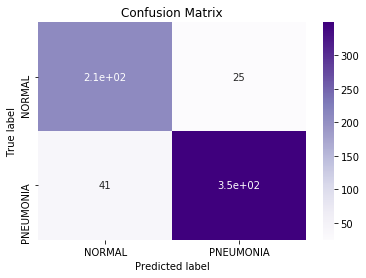

Precision Score: 0.9331550802139037
Recall Score: 0.8948717948717949
Accuracy Score: 0.8942307692307693
F1 Score: 0.9136125654450262


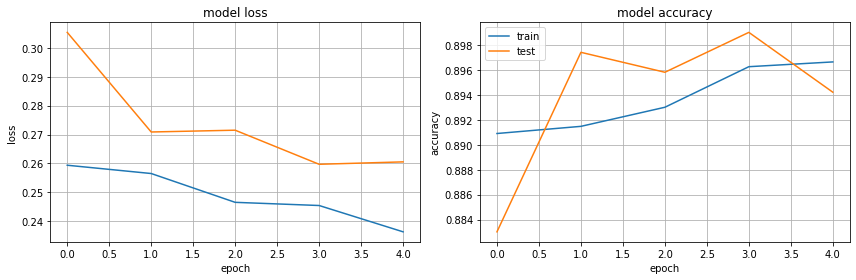

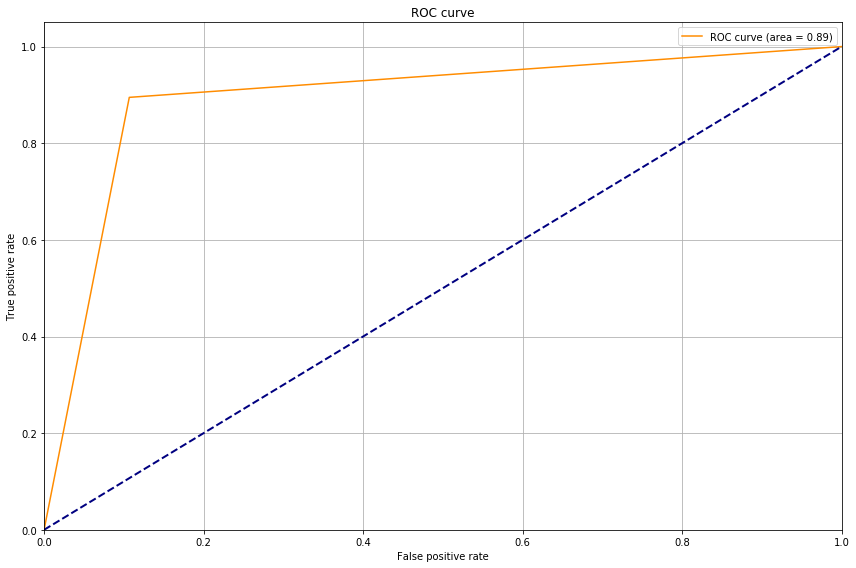

In [175]:
## Confusion matrix
plot_confusion_matrix(h1, test_gen, batch_size)
## Learning curve
plot_learning_curves(h2)
## ROC AUC
multiclass_roc_auc_score(test_gen, h1)

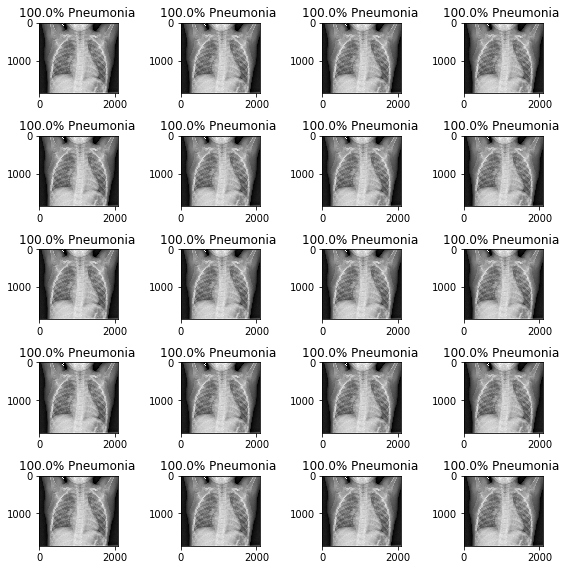

In [437]:
show_img(train_dir, train_gen)

## VGG19

In [ ]:
# VGG19
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

train = "chest_xray/chest_xray/train/"
test =  "chest_xray/chest_xray/test/"

ig_size=224
root = glob('chest_xray/chest_xray/train/*')
epoch = 5
batch_size = 32

vgg = VGG19(input_shape = ig_size + [3], weights = 'imagenet', include_top = False)

for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)


x = Dense(480, activation='relu')(x)

pred = Dense(len(root), activation = 'softmax' )(x)

train_gen, test_gen  = process_data(train, test, ig_size, batch_size)

vgg191, vgg192  = get_model(vgg, train_gen, test_gen, epoch)

##  VGG19 Testing

In [ ]:
## Confusion matrix
plot_confusion_matrix(vgg191, test_gen, batch_size)
## Learning curve
plot_learning_curves(vgg192)
## ROC AUC
multiclass_roc_auc_score(test_gen, vgg191)

## InceptionV3

In [50]:
## InceptionV3

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input 


train = "chest_xray/chest_xray/train/"
test =  "chest_xray/chest_xray/test/"

ig_size=224
root = glob('chest_xray/chest_xray/train/*')
epoch = 5
batch_size = 32

inc = InceptionV3(input_shape = ig_size + [3], weights = 'imagenet', include_top = False)

for layer in inc.layers:
    layer.trainable = False

x = Flatten()(inc.output)


x = Dense(480, activation='relu')(x)

pred = Dense(len(root), activation = 'softmax' )(x)

train_gen, test_gen  = process_data(train, test, ig_size, batch_size)

inc1, inc2  = get_model(inc, train_gen, test_gen, epoch)


87916544/87910968 [==============================] - 18s 0us/step
Model: "functional_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
____________________

Total params: 28,373,282
Trainable params: 6,570,498
Non-trainable params: 21,802,784
__________________________________________________________________________________________________
Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/5
 11/163 [=>............................] - ETA: 6:35 - loss: 6.6419 - accuracy: 0.6847

KeyboardInterrupt: 

## InceptionV3 Testing

In [ ]:
## Confusion matrix
plot_confusion_matrix(inc1, test_gen, batch_size)
## Learning curve
plot_learning_curves(inc2)
## ROC AUC
multiclass_roc_auc_score(test_gen, inc1)

## MobileNet

In [30]:
## MobileNet

from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input

train = "chest_xray/chest_xray/train/"
test =  "chest_xray/chest_xray/test/"

ig_size=224
root = glob('chest_xray/chest_xray/train/*')
epoch = 5
batch_size = 32

mobn = MobileNet(input_shape = ig_size + [3], weights = 'imagenet', include_top = False)

for layer in inc.layers:
    layer.trainable = False

x = Flatten()(mobn.output)


x = Dense(480, activation='relu')(x)

pred = Dense(len(root), activation = 'softmax' )(x)

train_gen, test_gen  = process_data(train, test, ig_size, batch_size)

mob1, mob2  = get_model(mobn, train_gen, test_gen, epoch)


Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/5
 38/163 [=====>........................] - ETA: 4:30 - loss: 7.0780 - accuracy: 0.8528

KeyboardInterrupt: 

## MobileNet Testing

In [ ]:
## Confusion matrix
plot_confusion_matrix(mob1, test_gen, batch_size)
## Learning curve
plot_learning_curves(mob2)
## ROC AUC
multiclass_roc_auc_score(test_gen, mob1)

## ResNet50

In [ ]:
## ResNet50

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input


train = "chest_xray/chest_xray/train/"
test =  "chest_xray/chest_xray/test/"

ig_size=224
root = glob('chest_xray/chest_xray/train/*')
epoch = 5
batch_size = 32

res = ResNet50(input_shape = ig_size + [3], weights = 'imagenet', include_top = False)

for layer in res.layers:
    layer.trainable = False

x = Flatten()(mobn.output)

# Adding a layer
x = Dense(480, activation='relu')(x)

pred = Dense(len(root), activation = 'softmax' )(x)

train_gen, test_gen  = process_data(train, test, ig_size, batch_size)

res1, res2  = get_model(res, train_gen, test_gen, epoch)      

## ResNet50 Testing

In [ ]:
## Confusion matrix
plot_confusion_matrix(res1, test_gen, batch_size)
## Learning curve
plot_learning_curves(res2)
## ROC AUC
multiclass_roc_auc_score(test_gen, res1)

In [ ]:
for index, probability in enumerate(y_pred):
    image_path = test_dir + "/" + test_gen.filenames[index]
    image = mpimg.imread(image_path)
    #BGR TO RGB conversion using CV2
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    fig=plt.figure(figsize=(8, 8))
    
    columns = 4
    rows = 5

    for i in range(1, columns*rows +1):
        
        fig.add_subplot(rows, columns, i)
        pixels = np.array(image)
        plt.imshow(pixels)

        
        if probability > 0.5:
            plt.title("%.1f" % (probability[0]*100) + "% Normal ")
        else:
            plt.title("%.1f" % ((1-probability[0])*100) + "% Pneumonia ")
    plt.tight_layout(True)
    plt.show()

In [4]:

# train_dir = "chest_xray/chest_xray/train/"
# test_dir =  "chest_xray/chest_xray/test/"
# def get_data(folder):
#     X = []
#     y = []
#     for folderName in os.listdir(folder):
#         if not folderName.startswith('.'):
#             if folderName in ['NORMAL']:
#                 label = 0
#             elif folderName in ['PNEUMONIA']:
#                 label = 1
#             else:
#                 label = 2
#             for image_filename in tqdm(os.listdir(folder + folderName)):
#                 img_file = cv2.imread(folder + folderName + '/' + image_filename)
#                 if img_file is not None:
#                     img_file = skimage.transform.resize(img_file, (224, 224, 3))
#                     #img_file = scipy.misc.imresize(arr=img_file, size=(150, 150, 3))
#                     img_arr = np.asarray(img_file)
#                     X.append(img_arr)
#                     y.append(label)
#     X = np.asarray(X)
#     y = np.asarray(y)
#     return X,y
# X_train, y_train = get_data(train_dir)
# X_test, y_test= get_data(test_dir)
# # Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
# from keras.utils.np_utils import to_categorical
# y_trainHot = to_categorical(y_train, num_classes = 2)
# y_testHot = to_categorical(y_test, num_classes = 2)

100%|████████████████████████████████████████| 390/390 [01:11<00:00,  5.49it/s]


In [ ]:
# np.save('X_train', X_train) 
# np.save('y_trainHot', y_trainHot) 
# np.save('X_test', X_test) 
# np.save('y_testHot', y_testHot) 


In [2]:
# y_trainHot = np.load('y_trainHot.npy') 
# X_test = np.load('X_test.npy') 
# X_test= np.load('y_testHot.npy') 


NameError: name 'np' is not defined

# Using Tomeklinks

In [ ]:
NUM_CLASSES = 2

X_train, y_train = load_dataset("chest_xray/chest_xray/train/", 6000)
X_test, y_test = load_dataset("chest_xray/chest_xray/test/", 6000)
X_val, y_val = load_dataset("chest_xray/chest_xray/val/", 6000)

In [13]:
X_flat_shape = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]
X_flat = X_train.reshape(X_train.shape[0], X_flat_shape)


In [ ]:
tl = TomekLinks()

X_res_tm , y_res_tm = tl.fit_resample(Train)
x_res_3d = X_res_tm.reshape(X_res_tm.shape[0],224,224,3)

In [161]:
h1.save("h1.h5")


AttributeError: 'History' object has no attribute 'save'